# Projet de Deep Learning :


=========== projet 6: prediction série temporelle =========

Nous considérons une série temporelle financière donnée de longueur totale N, S_t, t=0,1,...,N.
Nt=0.8*N (entrainement), Nv=0.2*N (validation) à télécharger sur internet ou à prendre une colonne dans 
https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv

Exemple N=255*10 (10 années de données journalières)

On calcule pour chaque point de la série initiale 
- les rendements R_t = np.log(X_t/X_{t-1})
- la moyenne des K derniers rendements, K=5 (=1 semaine: 1W), K=25 (1 mois: 1M), K=3*25 (3M); K=6*25 (6M), K=255 (1Y), K=3Y
- la volatilité (annualisée) des K derniers rendements sur la même période

On ajoute pour chaque point : 
- les calculs précédents (1+7*2 = 15 données)
- le prix en 't', (1 donnée)
- la moyenne exponentielle (EMA) des derniers K prix divisé par le prix en t (7 données)
- une fenetre de longueur "n" des prix S_{t-n} ... S_t,  par exemple n=3*25 (3 mois) : n données .

Attention: parfois il n'est pas possible de calculer par exemple la moyenne sur les 3 dernières année car pas assez de données. Alors la prendre égale à la plus longue qu'il est possible de calculer (ne pas mettre "nan").

Donc la base de données contient N-1 points.
A prevoir: le rendement suivant en R_{t+1}


Chargement des packages et lib nécéssaires 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [20]:
# Charger les données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"
data = pd.read_csv(url, sep=";")

# Nettoyage des données : On conserve seulement BNP.PA et on supprime les lignes avec des NA

data = data[['Date', 'BNP.PA']].dropna()


# Conversion de la colonne Date en datetime
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

display(data)

,BNP.PA
Date,
2000-01-03,16.165972
2000-01-04,15.711578
2000-01-05,15.379528
2000-01-06,14.855226
2000-01-07,15.047465
...,...
1999-12-27,16.008684
1999-12-28,15.938777
1999-12-29,16.078594


Train RMSE: 0.016388614120192987
Validation RMSE: 0.02556490032324198


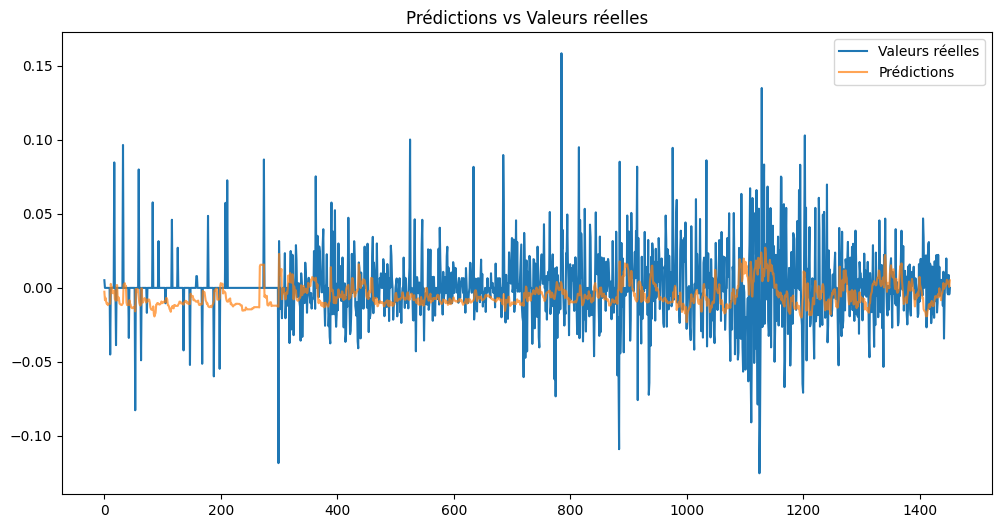

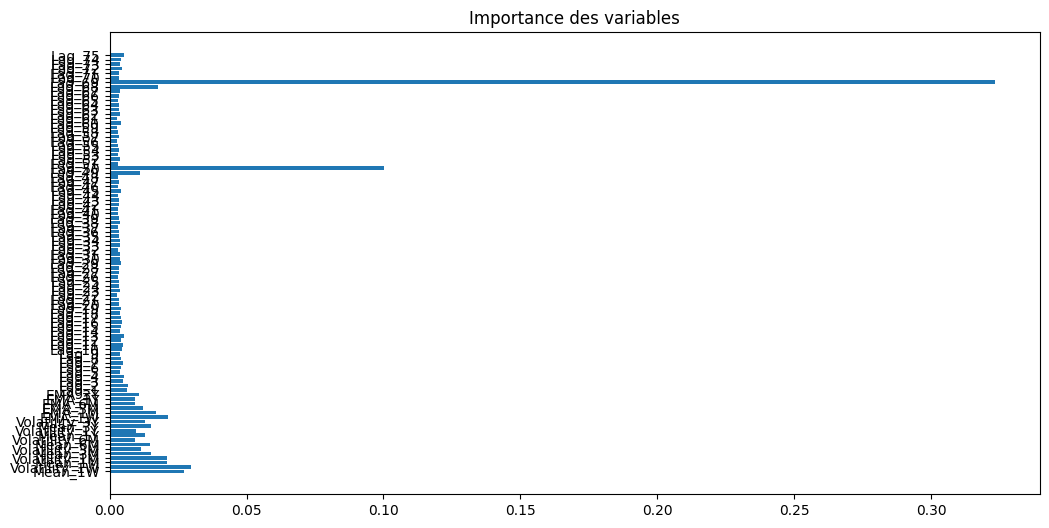

In [21]:
# Calcul des rendements logarithmiques
data['Return'] = np.log(data['BNP.PA'] / data['BNP.PA'].shift(1))

# Définition des périodes d'analyse
periods = {
    "1W": 5,
    "1M": 25,
    "3M": 3 * 25,
    "6M": 6 * 25,
    "1Y": 255,
    "3Y": 3 * 255
}

# Calcul des moyennes et des volatilités
for period_name, K in periods.items():
    data[f'Mean_{period_name}'] = data['Return'].rolling(window=K, min_periods=1).mean()
    data[f'Volatility_{period_name}'] = data['Return'].rolling(window=K, min_periods=1).std() * np.sqrt(255)

# Calcul des EMA (moyennes exponentielles)
for period_name, K in periods.items():
    data[f'EMA_{period_name}'] = data['BNP.PA'].ewm(span=K, adjust=False).mean() / data['BNP.PA']

# Ajout des fenêtres de prix pour une période donnée (exemple : 3 mois)
n = 3 * 25  # 3 mois
for i in range(1, n + 1):  # Décalages pour une fenêtre glissante
    data[f'Lag_{i}'] = data['BNP.PA'].shift(i)

# Suppression des lignes contenant des valeurs manquantes
data = data.dropna()

# Cible : Rendement futur
data['Future_Return'] = data['Return'].shift(-1)

# Suppression des lignes NaN après le calcul de la cible
data = data.dropna()

# Division en ensembles d'entraînement et de validation
N = len(data)
N_train = int(0.8 * N)

train_data = data[:N_train]
val_data = data[N_train:]

# Extraction des caractéristiques (X) et de la cible (y)
X_train = train_data.drop(columns=['BNP.PA', 'Return', 'Future_Return'])
y_train = train_data['Future_Return']

X_val = val_data.drop(columns=['BNP.PA', 'Return', 'Future_Return'])
y_val = val_data['Future_Return']

# Modélisation : Exemple avec un modèle Random Forest
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Prédictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Évaluation des performances
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")

# Analyse des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_val.reset_index(drop=True), label="Valeurs réelles")
plt.plot(y_pred_val, label="Prédictions", alpha=0.7)
plt.legend()
plt.title("Prédictions vs Valeurs réelles")
plt.show()

# Importance des caractéristiques
feature_importances = model.feature_importances_
plt.figure(figsize=(12, 6))
plt.barh(X_train.columns, feature_importances)
plt.title("Importance des variables")
plt.show()